### Predict CO2 emissions from Mauna Lao volcano

In [128]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


In [129]:
co2_df = pd.read_csv("../ts-course-data/co2.csv", index_col = "Date", parse_dates=True)
co2_df.index.freq = "MS"

In [130]:
co2_df.head(5)

,CO2
Date,
1959-01-01,315.42
1959-02-01,316.31
1959-03-01,316.50
1959-04-01,317.56
1959-05-01,318.13


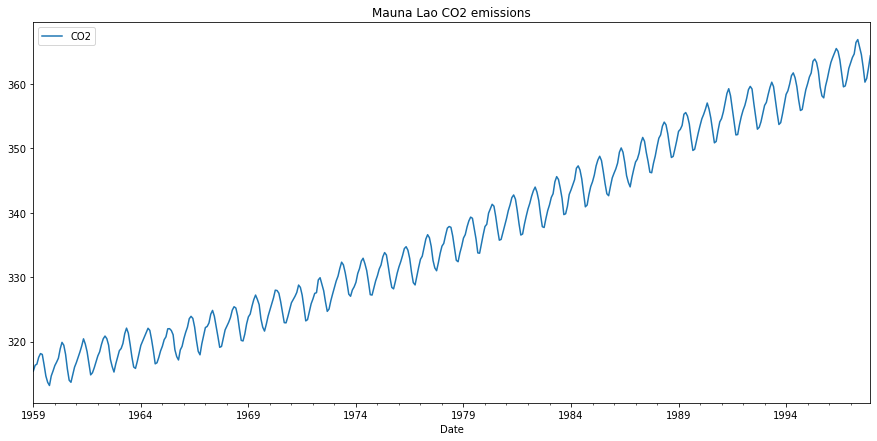

In [131]:
co2_df.plot(figsize = (15, 7), title = "Mauna Lao CO2 emissions")
plt.show()

In [132]:
# It does look like there is a linear trend plus seasonality

In [133]:
# fit a basic linear regression model using DeterministicProcess
# split the df into train and test, lets use 10% data as the test dataset

dp = DeterministicProcess (
    index=co2_df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True
)

X = dp.in_sample()
y = co2_df.loc[:, "CO2"]


In [134]:
X_train, X_test = train_test_split(X, test_size = 0.1, shuffle = False)
y_train, y_test = train_test_split(y, test_size = 0.1, shuffle = False)

In [135]:
X_train.head(4), y_train.head(4)

(            const  trend
 Date                    
 1959-01-01    1.0    1.0
 1959-02-01    1.0    2.0
 1959-03-01    1.0    3.0
 1959-04-01    1.0    4.0,
 Date
 1959-01-01    315.42
 1959-02-01    316.31
 1959-03-01    316.50
 1959-04-01    317.56
 Freq: MS, Name: CO2, dtype: float64)

In [136]:
X_test.head(4), y_test.head(4)

(            const  trend
 Date                    
 1994-02-01    1.0  422.0
 1994-03-01    1.0  423.0
 1994-04-01    1.0  424.0
 1994-05-01    1.0  425.0,
 Date
 1994-02-01    358.89
 1994-03-01    359.95
 1994-04-01    361.25
 1994-05-01    361.67
 Freq: MS, Name: CO2, dtype: float64)

In [137]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_test), index=X_test.index)

In [138]:
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("rmse is {}".format(rmse))

rmse is 3.345405306433459


### RMSE using basic linear regression model on just time dummy trend is 3.34

In [139]:
y_pred.head(4)

Date
1994-02-01    356.680457
1994-03-01    356.786486
1994-04-01    356.892515
1994-05-01    356.998544
Freq: MS, dtype: float64

In [140]:
y_test.head(4)

Date
1994-02-01    358.89
1994-03-01    359.95
1994-04-01    361.25
1994-05-01    361.67
Freq: MS, Name: CO2, dtype: float64

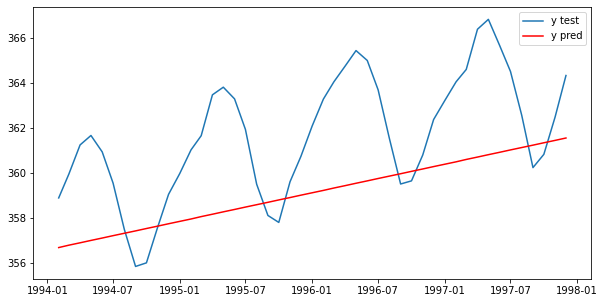

In [141]:
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y_test, label = "y test")
ax.plot(y_pred, color = "red", label = "y pred")
plt.legend()
plt.show()

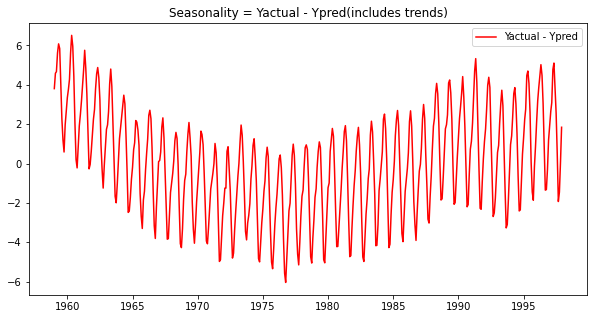

In [142]:
# Lets try to add seasonality.
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y - y_pred, color = "red", label = "Yactual - Ypred")
plt.title("Seasonality = Yactual - Ypred(includes trends)")
plt.legend()
plt.show()

In [143]:
# Merging the trend + seasonality
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=co2_df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # monthly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample() 
y = co2_df.loc[:, "CO2"]

X.head(5)

,const,trend,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)",...,"cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)","sin(6,freq=A-DEC)"
Date,,,,,,,,,,,,,,,,,,,,,
1959-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1959-02-01,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.860961,0.875892,0.482508,0.999546,-0.030120,0.845249,-0.534373,0.455907,-0.890028,-0.060213
1959-03-01,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.527078,0.895839,-0.444378,0.094537,-0.995521,-0.796183,-0.605056,-0.933837,0.357698,-0.188227
1959-04-01,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.021516,0.043022,-0.999074,-0.997917,-0.064508,-0.085965,0.996298,0.994218,0.107381,0.128748
1959-05-01,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.474951,-0.835925,-0.548843,-0.085965,0.996298,0.917584,-0.397543,-0.785650,-0.618671,-0.171293


In [144]:
X_train, X_test = train_test_split(X, test_size = 0.1, shuffle = False)
y_train, y_test = train_test_split(y, test_size = 0.1, shuffle = False)

In [145]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_test), index=X_test.index)

In [146]:
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("rmse is {}".format(rmse))

rmse is 2.5137184554413423


### RMSE is reduced from 3.34 (just linear trend) to 2.51 using seasonality (monthly and yearly)

In [147]:
y_pred.head(4)

Date
1994-02-01    357.324110
1994-03-01    358.209495
1994-04-01    359.412187
1994-05-01    360.027187
Freq: MS, dtype: float64

In [148]:
y_test.head(5)

Date
1994-02-01    358.89
1994-03-01    359.95
1994-04-01    361.25
1994-05-01    361.67
1994-06-01    360.94
Freq: MS, Name: CO2, dtype: float64

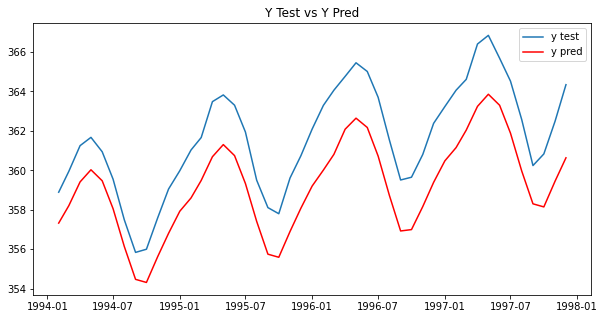

In [149]:
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y_test, label = "y test")
ax.plot(y_pred, color = "red", label = "y pred")
plt.title("Y Test vs Y Pred")
plt.legend()
plt.show()

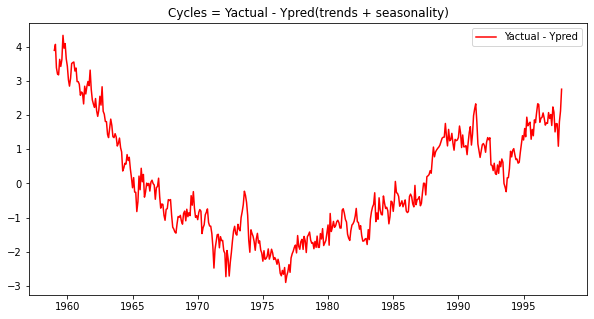

In [150]:
# Lets try to add cycles.
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y - y_pred, color = "red", label = "Yactual - Ypred")
plt.title("Cycles = Yactual - Ypred(trends + seasonality)")
plt.legend()
plt.show()

In [151]:
# lets add a lag of 1

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=co2_df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample() 
y = co2_df.loc[:, "CO2"]

X["lag_1"] = y.shift(1) # adding a lag of 1 for cycles
X = X.iloc[1: , :] # dropping the first row with NaN
y = y[1:]
X_train, X_test = train_test_split(X, test_size = 0.1, shuffle = False)
y_train, y_test = train_test_split(y, test_size = 0.1, shuffle = False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_test), index=X_test.index)

rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("rmse is {}".format(rmse))

rmse is 0.3282836369353317


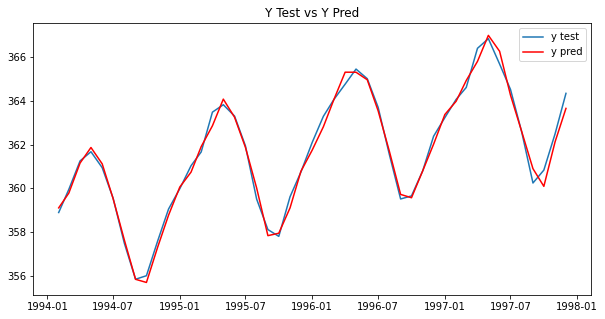

In [152]:
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y_test, label = "y test")
ax.plot(y_pred, color = "red", label = "y pred")
plt.title("Y Test vs Y Pred")
plt.legend()
plt.show()

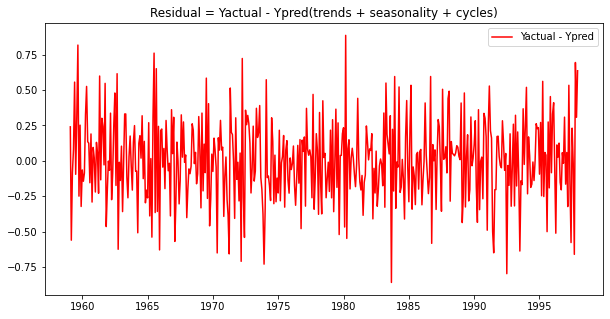

In [153]:
# get the residual

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y - y_pred, color = "red", label = "Yactual - Ypred")
plt.title("Residual = Yactual - Ypred(trends + seasonality + cycles)")
plt.legend()
plt.show()

In [154]:
# Train XGBoost on the residuals
from sklearn.ensemble import GradientBoostingRegressor
y_residual = y - y_pred

X_train_residual, X_test_residual = train_test_split(X, test_size = 0.1, shuffle = False)
y_train_residual, y_test_residual = train_test_split(y_residual, test_size = 0.1, shuffle = False)

model = GradientBoostingRegressor()
model.fit(X_train_residual, y_train_residual)

y_pred_residual = pd.Series(model.predict(X_test_residual), index=X_test_residual.index)

rmse = np.sqrt(mean_squared_error(y_pred_residual, y_test_residual))
print("rmse is {}".format(rmse))

rmse is 0.35426230020417265


In [155]:
y_test_residual.head(4), y_pred_residual.head(4)

(Date
 1994-02-01   -0.233191
 1994-03-01    0.169147
 1994-04-01    0.036254
 1994-05-01   -0.187903
 Freq: MS, dtype: float64,
 Date
 1994-02-01    0.102360
 1994-03-01    0.145288
 1994-04-01    0.110990
 1994-05-01    0.308518
 Freq: MS, dtype: float64)

In [156]:
len(y_test_residual), len(y_pred_residual)

(47, 47)

In [157]:
model = GradientBoostingRegressor()
model.fit(X, y_residual)

y_pred_residual = pd.Series(model.predict(X), index=X.index)

In [158]:
# overall y is the sum of y predicted from trends + seasonality + cycles (from Linear Regression) and 
# y predicted from residual using XGBoostRegressor
final_y = y_pred + y_pred_residual

In [159]:
print(y_pred.head(4), y_pred_residual.head(4), final_y.head(4))

Date
1959-02-01    316.069860
1959-03-01    317.060938
1959-04-01    317.640679
1959-05-01    318.049484
Freq: MS, dtype: float64 Date
1959-02-01    0.145808
1959-03-01   -0.464473
1959-04-01   -0.064551
1959-05-01    0.152876
Freq: MS, dtype: float64 Date
1959-02-01    316.215668
1959-03-01    316.596465
1959-04-01    317.576128
1959-05-01    318.202360
Freq: MS, dtype: float64


In [160]:
y_pred, final_y

(Date
 1959-02-01    316.069860
 1959-03-01    317.060938
 1959-04-01    317.640679
 1959-05-01    318.049484
 1959-06-01    317.443718
                  ...    
 1997-08-01    362.585774
 1997-09-01    360.901107
 1997-10-01    360.135141
 1997-11-01    362.182325
 1997-12-01    363.703483
 Freq: MS, Length: 467, dtype: float64,
 Date
 1959-02-01    316.215668
 1959-03-01    316.596465
 1959-04-01    317.576128
 1959-05-01    318.202360
 1959-06-01    317.842442
                  ...    
 1997-08-01    362.508606
 1997-09-01    360.427734
 1997-10-01    360.744086
 1997-11-01    362.488892
 1997-12-01    364.258539
 Freq: MS, Length: 467, dtype: float64)

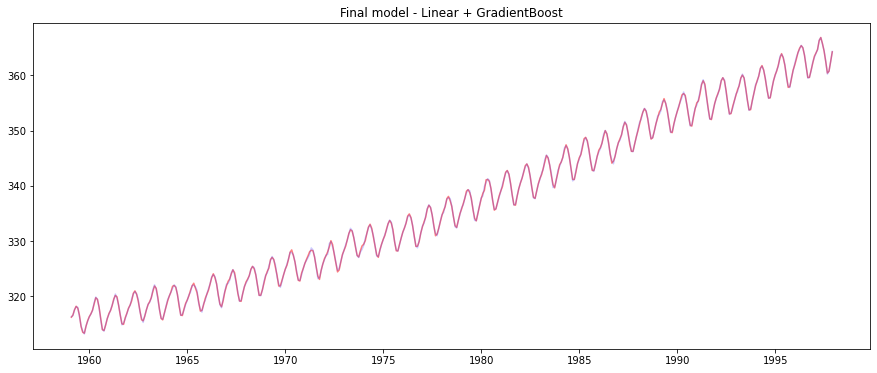

In [161]:
plt.figure(figsize = (15, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(final_y, color = "red", label = "Y Pred", alpha = 0.5)
ax.plot(y, color = "blue", label = "Actual Y", alpha = 0.2)
plt.title("Final model - Linear + GradientBoost")
plt.show()

In [162]:
_, final_y_test = train_test_split(final_y, test_size = 0.1, shuffle = False)

rmse = np.sqrt(mean_squared_error(final_y_test, y_test))
print("rmse is {}".format(rmse))

rmse is 0.14981592855337778


### RMSE using combination of both Linear and Gradient Boost is 0.149 on the test dataset

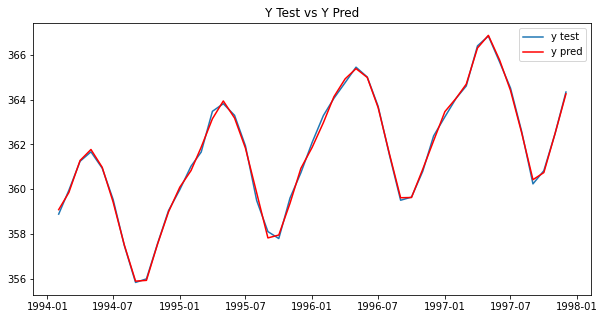

In [163]:
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y_test, label = "y test")
ax.plot(final_y_test, color = "red", label = "y pred")
plt.title("Y Test vs Y Pred")
plt.legend()
plt.show()


In [164]:
# Perfecto!